# Acquisition notebook

- This notebook is to visualize and clean the data downloaded because it is safe to assume that the unsorted data needs to be organised and looked at
- Note even this early in the project there are extreme limitations on what is available via free API for Reddit so meaningful research will be very limited.


In [ ]:
# =========================================================================================
# Cell 1: Set up Paths, Imports, and Diagnostics
# =========================================================================================

import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

# --- Add project root to Python's path ---
# This allows us to import our custom 'src' package
# We assume the notebook is in a subfolder (like 'notebooks') of the project root
project_root = os.path.abspath(os.path.join(CWD, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project Root added to path: {project_root}")
# ---------------------------------------------------

# Now we can import our config file, which is the single source of truth
from src import config

# Set pandas display options
pd.set_option('display.max_colwidth', 100)

Current Working Directory: /Users/adrianbingham-walker/Documents/reddit_crypto/notebooks
Project Root added to path: /Users/adrianbingham-walker/Documents/reddit_crypto


In [11]:
# =========================================================================================
# Cell 2: Load Data into Dataframes 
# =========================================================================================

# The paths are now taken directly from our central config file.
btc_path_absolute = os.path.join(project_root, config.RAW_BTC_MARKET_DATA_PATH)
eth_path_absolute = os.path.join(project_root, config.RAW_ETH_MARKET_DATA_PATH)
reddit_path_absolute = os.path.join(project_root, config.RAW_REDDIT_DATA_PATH)

print(f"\nLoading BTC data from: {btc_path_absolute}")
btc_df = pd.read_parquet(btc_path_absolute)

print(f"Loading ETH data from: {eth_path_absolute}")
eth_df = pd.read_parquet(eth_path_absolute)

print(f"Loading Reddit data from: {reddit_path_absolute}")
reddit_df = pd.read_parquet(reddit_path_absolute)

print("\n--- All data loaded successfully ---")

# Now you can inspect the dataframes
print("\n--- Bitcoin Data Info ---")
btc_df.info()

print("\n--- Reddit Post Data Info ---")
reddit_df.info()


Loading BTC data from: /Users/adrianbingham-walker/Documents/reddit_crypto/data/raw/btc_usd_market_data_1h.parquet
Loading ETH data from: /Users/adrianbingham-walker/Documents/reddit_crypto/data/raw/eth_usd_market_data_1h.parquet
Loading Reddit data from: /Users/adrianbingham-walker/Documents/reddit_crypto/data/raw/raw_reddit_data_aggressive-praw_limit5000.parquet

--- All data loaded successfully ---

--- Bitcoin Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2024-09-26 09:00:00+00:00 to 2025-09-26 09:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj_close  8760 non-null   float64
 1   close      8760 non-null   float64
 2   high       8760 non-null   float64
 3   low        8760 non-null   float64
 4   open       8760 non-null   float64
 5   volume     8760 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 479.1 KB

--- Reddit Post Data Info ---
<class 'pa

In [5]:
# =========================================================================================
# Cell 3: Market Sanity checks, are there enough entries, no duplicates and silly numbers
# =========================================================================================

print("--- Market Data Sanity Checks ---")

# 1. Check for missing data (gaps in the timeline)
# We expect ~365 * 24 = 8760 rows. This looks good from the .info() output.
full_range = pd.date_range(start=btc_df.index.min(), end=btc_df.index.max(), freq='1h')
missing_timestamps = full_range.difference(btc_df.index)
print(f"Number of missing hourly timestamps in BTC data: {len(missing_timestamps)}")

# 2. Check for duplicate timestamps
duplicate_timestamps = btc_df.index.duplicated().sum()
print(f"Number of duplicate timestamps in BTC data: {duplicate_timestamps}")

# 3. Check summary statistics
# Are prices/volumes in a reasonable range? Are there any zeros where there shouldn't be?
print("\nBTC Summary Statistics:")
btc_df.describe()

--- Market Data Sanity Checks ---
Number of missing hourly timestamps in BTC data: 1
Number of duplicate timestamps in BTC data: 0

BTC Summary Statistics:


,adj_close,close,high,low,open,volume
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8.760000e+03
mean,96864.523189,96864.523189,97122.475042,96595.514289,96857.796693,5.785216e+08
std,15332.323012,15332.323012,15336.971643,15330.374547,15336.168475,1.427062e+09
min,59323.363281,59323.363281,59433.148438,58895.207031,59424.828125,0.000000e+00
25%,86506.226562,86506.226562,86835.244141,86091.220703,86458.675781,0.000000e+00
50%,98068.886719,98068.886719,98314.308594,97806.019531,98074.937500,0.000000e+00
75%,108274.244141,108274.244141,108490.166016,108083.496094,108267.720703,6.989793e+08
max,123810.921875,123810.921875,124322.289062,123414.031250,123869.304688,3.461036e+10


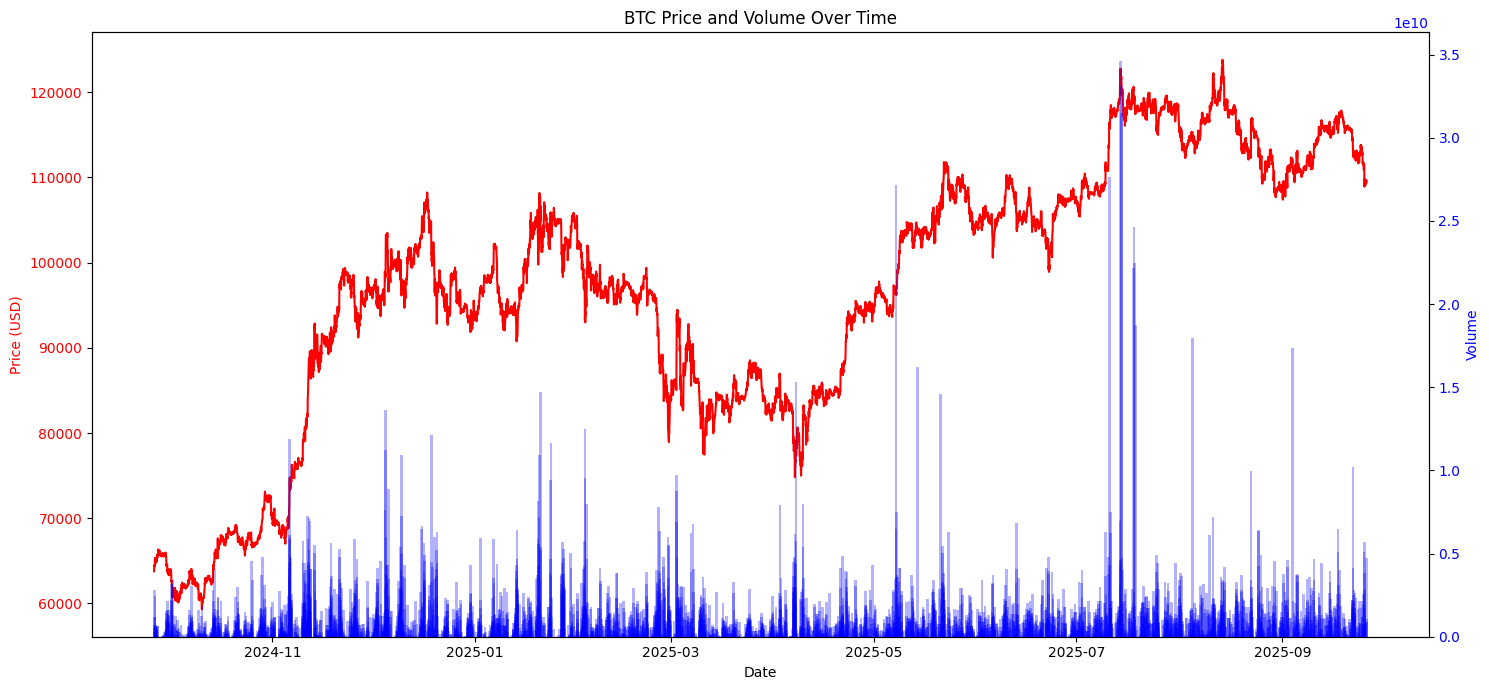

In [6]:
# =========================================================================================
# Cell 4: Market Sanity checks graphing to have visual check
# =========================================================================================

# A simple plot is the best way to spot anomalies
fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.set_title('BTC Price and Volume Over Time')
ax1.plot(btc_df.index, btc_df['close'], color='red', label='BTC Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Create a second y-axis for volume
ax2 = ax1.twinx()
ax2.bar(btc_df.index, btc_df['volume'], color='blue', alpha=0.3, label='Volume')
ax2.set_ylabel('Volume', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()
plt.show()

In [7]:
# =========================================================================================
# Cell 5: Reddit Sanity checks, are there enough entries, no duplicates and silly numbers
# =========================================================================================

print("--- Reddit Data Sanity Checks ---")

# 1. Check the date range to see what we actually captured
print(f"Oldest post timestamp: {reddit_df['timestamp_utc'].min()}")
print(f"Newest post timestamp: {reddit_df['timestamp_utc'].max()}")
# Note: PRAW search is not chronological. This is expected.

# 2. Check for common junk text in the 'body' column
print("\nMost common post bodies:")
print(reddit_df['body'].value_counts().head())

# --- DATA CLEANING ---
# Let's remove posts where the body is just '[removed]' or '[deleted]'
initial_rows = len(reddit_df)
reddit_df = reddit_df[~reddit_df['body'].isin(['[removed]', '[deleted]'])]
print(f"\nRemoved {initial_rows - len(reddit_df)} posts with '[removed]' or '[deleted]' body.")

# 3. Check distribution of scores and comments
print("\nSummary statistics for score and comments:")
reddit_df[['score', 'num_comments']].describe()

--- Reddit Data Sanity Checks ---
Oldest post timestamp: 2025-06-05 20:05:31+00:00
Newest post timestamp: 2025-09-26 09:06:50+00:00

Most common post bodies:
body
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

,score,num_comments
count,821.000000,821.000000
mean,76.133983,33.099878
std,288.644497,84.800410
min,0.000000,0.000000
25%,3.000000,4.000000
50%,13.000000,11.000000
75%,50.000000,30.000000
max,6794.000000,994.000000


--- Post Mentions per Crypto ---
mentioned_crypto
BTC    513
ETH    409
Name: count, dtype: int64


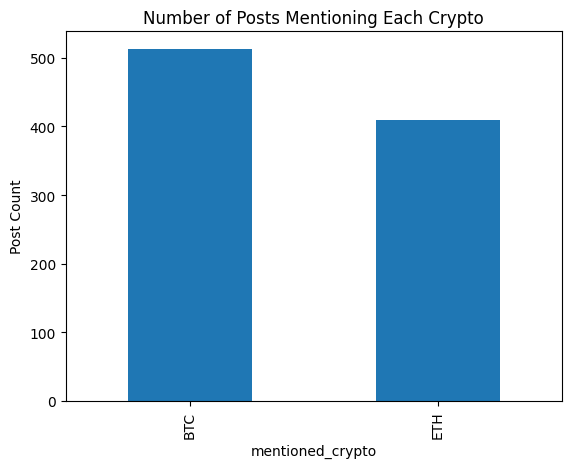

In [ ]:
# =========================================================================================
# Cell 6: Qualitative Analysis - Reading Random Samples
# =========================================================================================

# How many posts did we get for each crypto?
# Since 'mentioned_crypto' is a list, we need to 'explode' it first
mention_counts = reddit_df.explode('mentioned_crypto')['mentioned_crypto'].value_counts()

print("--- Post Mentions per Crypto ---")
print(mention_counts)

mention_counts.plot(kind='bar', title='Number of Posts Mentioning Each Crypto')
plt.ylabel('Post Count')
plt.show()

# THIS IS A MAJOR PROBLEM THAT WE ARE NOT ABLE TO EXTRACT A LARGE NUMNER OF POSTS

In [12]:
# =========================================================================================
# Cell 7: Qualitative Analysis - Reading Random Samples
# =========================================================================================

# Set pandas to show the full text of the 'body' column
pd.set_option('display.max_colwidth', None)

print("--- Random Sample of 15 Posts ---")
# The .sample() method is perfect for this.
# We are interested in the title, body, and score.
random_sample = reddit_df[['title', 'body', 'score']].sample(15, random_state=42) # random_state makes it reproducible

random_sample

--- Random Sample of 15 Posts ---


title  \
609                                     [AMA] We are EF Protocol (Pt. 14: 29 August, 2025)   
174                                                           Robinhood for Crypto - Don’t   
67                    BlackRock raking in $260M in annual revenue from Bitcoin, Ether ETFs   
168                         Launchpads - Which ones are actually aligned with their users?   
275                                                The Simpsons blazing BTC advertisement.   
335                                                Buying bitcoin as privately as possible   
807                                                               This noob need some help   
86   Tom Lee's BitMine discloses 2.4 million Ethereum and over $11 billion in total assets   
539                                         Learn Bitcoin and Hedge against This Horror...   
713                                   how to transfer eth from main net to immutable zkevm   
819                             Someone hacked and drained my ETH Wallet ! Call for Help !   
265                                                         For those that don't get it...   
411                                                                   Passing BTC to heirs   
30                    Ether supply on exchanges hits 9-year low amid ‘Wall Street glow up’   
725                                            Who’s in NYC! Ethnyc 11-17 August announced   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [ ]:
# =========================================================================================
# Cell 8: Programmatic Noise Investigation
# =========================================================================================

# --- 1. Look for Short/Empty Posts ---
# Combine title and body to get the full text length
reddit_df['text_length'] = reddit_df['title'].str.len() + reddit_df['body'].fillna('').str.len()

print("--- Posts with the Shortest Text Length ---")
print(reddit_df.sort_values(by='text_length', ascending=True)[['title', 'body', 'text_length']].head(10))

# --- 2. Look for Excessive Links ---
# Count the number of 'http' occurrences as a proxy for links
reddit_df['link_count'] = reddit_df['body'].str.count('http')

print("\n--- Posts with the Most Links ---")
print(reddit_df.sort_values(by='link_count', ascending=False)[['title', 'link_count']].head(10))

# --- 3. Look for Excessive Emojis ---
import emoji
reddit_df['emoji_count'] = reddit_df['body'].apply(lambda text: emoji.emoji_count(str(text)))

print("\n--- Posts with the Most Emojis ---")
print(reddit_df.sort_values(by='emoji_count', ascending=False)[['title', 'emoji_count']].head(10))

--- Posts with the Shortest Text Length ---
                         title body  text_length
362               BTC necklace                12
65              New to Bitcoin                14
379             Bitcoin is Big                14
290           Bitcoin is money                16
420         Bitcoin Rap Battle                18
414      Bitcoin is everything                21
795     Ethereum: Digital Oil?                22
346     It's All About Bitcoin                22
246    Epic Pro Bitcoiner Move                23
499  Classic Bitcoin excuser 🙃                25

--- Posts with the Most Links ---
                                                                                                                                   title  \
767                                                                     I went to ETHPrague so you don't have to (but you should anyway)   
693                                                                           The Doots Podcast – This